# Clustering:

## find (fixed) locations which had the greatest number of objects

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
import psycopg2
import pandas as pd
from sklearn.cluster import DBSCAN
import seaborn as sns
from scipy.spatial import ConvexHull

/var/folders/vm/dc_xrvyx49q2nbd6bgbrlxnw0000gn/T/ipykernel_40129/3155098632.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


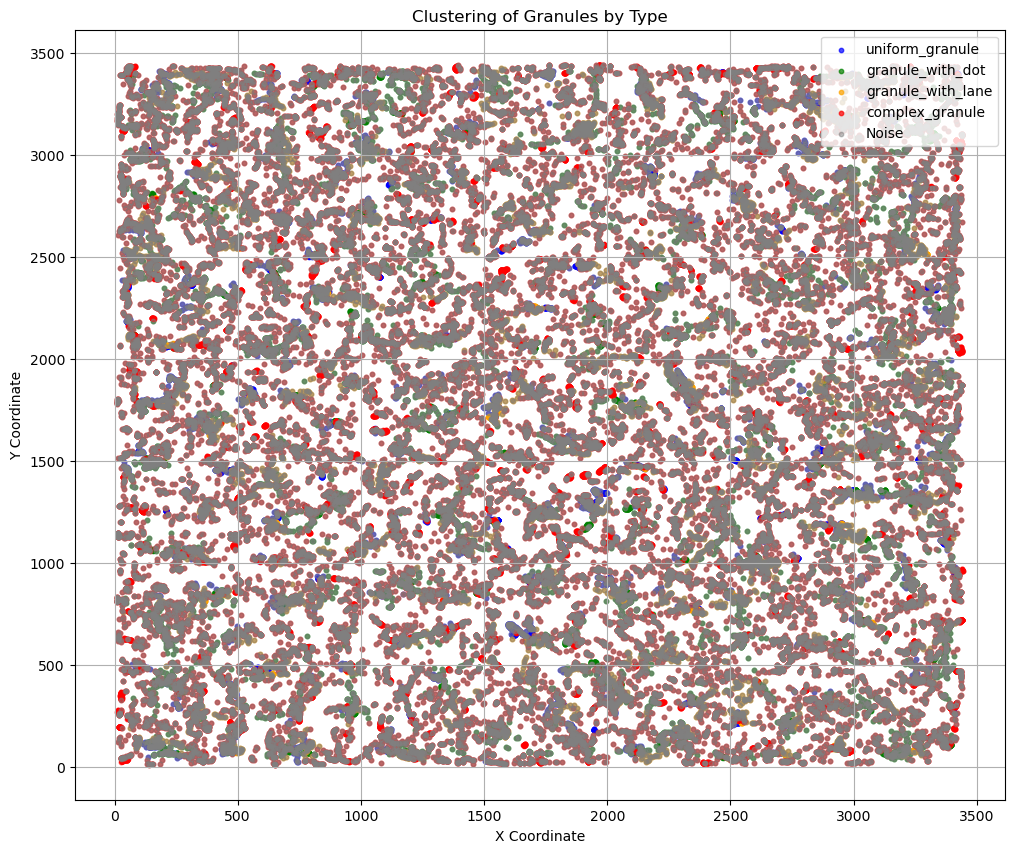

In [3]:
#explain DBSCAN 1 or 2 slides, more representative figures (clustering without the centroids) , 
#use DBSCAN with different parameters with much smaller scope '5 diff.'
db_params = {
    "host": "150.230.166.174",
    "database": "dkist",
    "user": "dkist",
    "password": "sdbsdb!"
}
query = """
SELECT 
    id,
    ST_X(ST_Centroid(shape)) AS x,
    ST_Y(ST_Centroid(shape)) AS y,
    'uniform_granule' AS granule_type
FROM uniform_granule

UNION ALL

SELECT 
    id,
    ST_X(ST_Centroid(shape)) AS x,
    ST_Y(ST_Centroid(shape)) AS y,
    'granule_with_dot' AS granule_type
FROM granule_with_dot

UNION ALL

SELECT 
    id,
    ST_X(ST_Centroid(shape)) AS x,
    ST_Y(ST_Centroid(shape)) AS y,
    'granule_with_lane' AS granule_type
FROM granule_with_lane

UNION ALL

SELECT 
    id,
    ST_X(ST_Centroid(shape)) AS x,
    ST_Y(ST_Centroid(shape)) AS y,
    'complex_granule' AS granule_type
FROM complex_granule

"""


def fetch_data(query, db_params):
    conn = psycopg2.connect(**db_params)
    df = pd.read_sql(query, conn)
    conn.close()
    return df


df = fetch_data(query, db_params)


X = df[['x', 'y']].to_numpy()


eps = 5  
min_samples = 10
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X)


df['cluster'] = db.labels_


granule_types = {
    "uniform_granule": "blue",
    "granule_with_dot": "green",
    "granule_with_lane": "orange",
    "complex_granule": "red",
   
}

plt.figure(figsize=(12, 10))


for granule_type, color in granule_types.items():
    granule_df = df[df['granule_type'] == granule_type] 
    plt.scatter(granule_df['x'], granule_df['y'], c=color, label=granule_type, s=10, alpha=0.7)


noise = df[df['cluster'] == -1]
plt.scatter(noise['x'], noise['y'], c='gray', label='Noise', s=10, alpha=0.5)


plt.title("Clustering of Granules by Type")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(loc="upper right")
plt.grid()
plt.show()


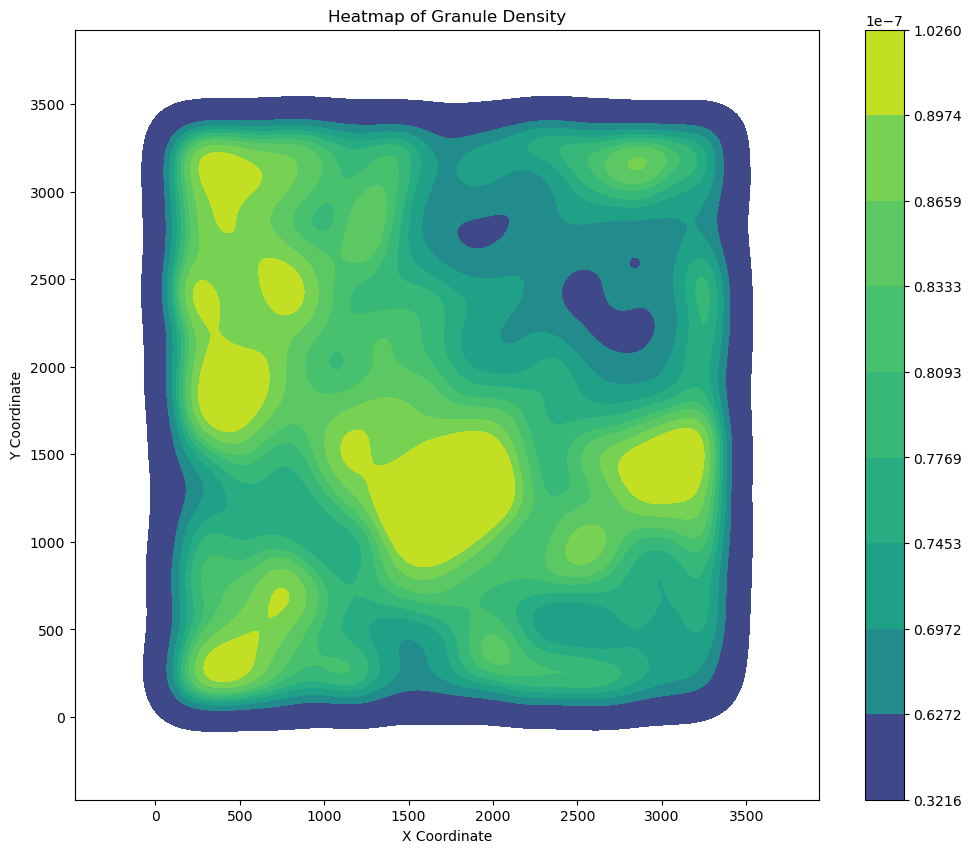

In [4]:
plt.figure(figsize=(12, 10))
sns.kdeplot(x=df['x'], y=df['y'], cmap="viridis", fill=True, cbar=True)
plt.title("Heatmap of Granule Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


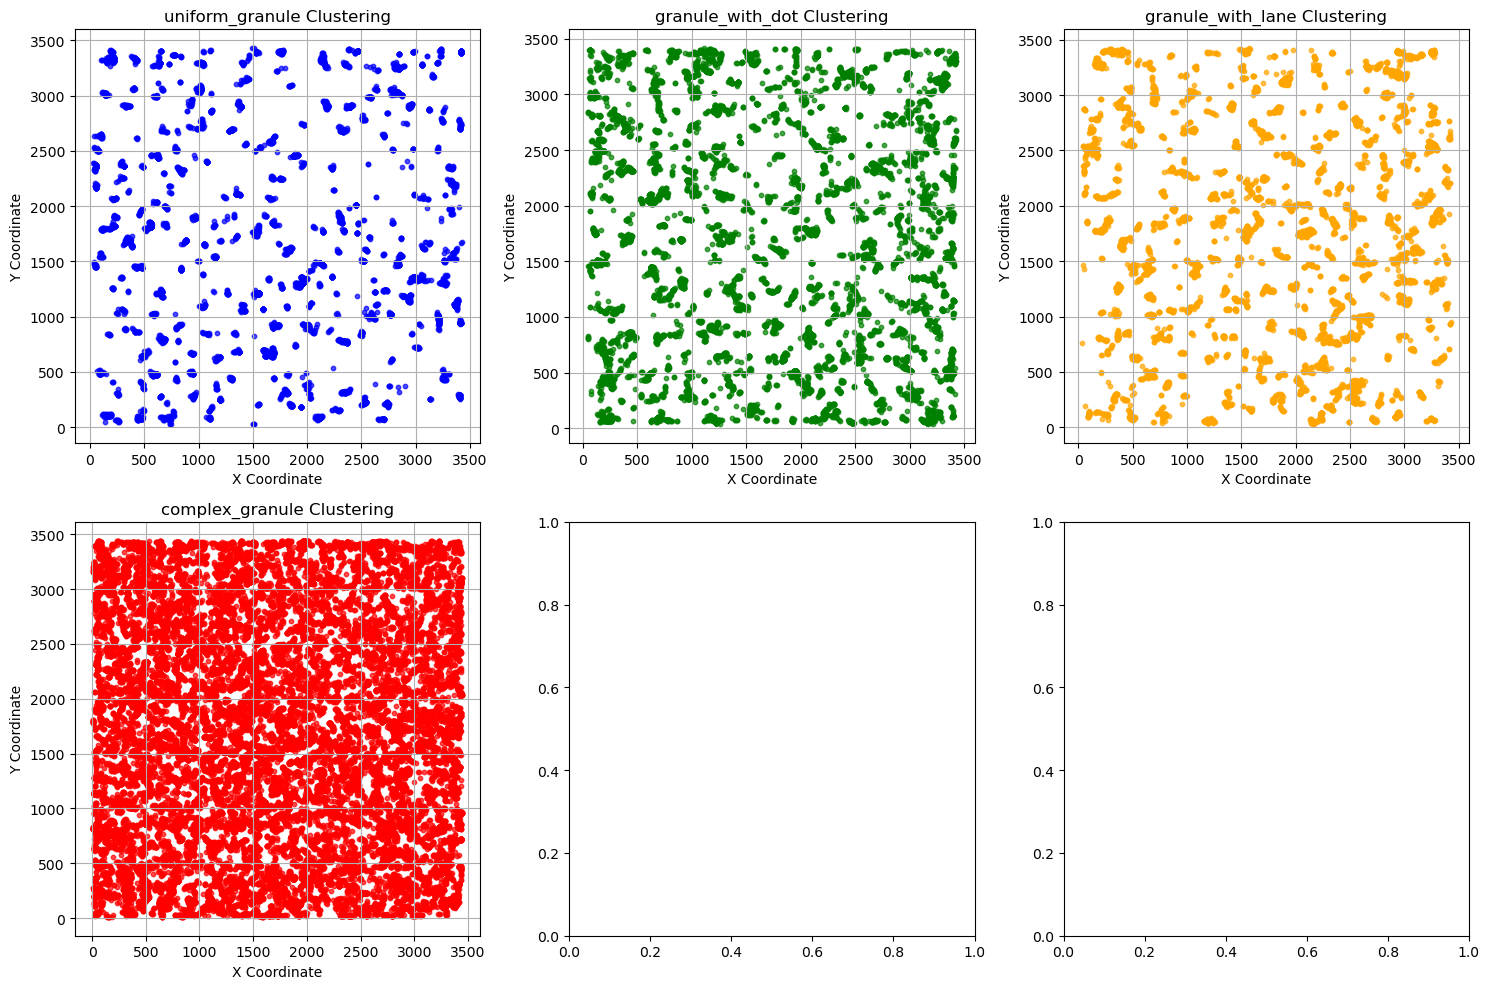

In [5]:
#make the clusters more represntative of the granules instead of the centroids, in one time frame 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.ravel() 

for idx, (granule_type, color) in enumerate(granule_types.items()):
    ax = axes[idx]
    granule_df = df[df['granule_type'] == granule_type]
    ax.scatter(granule_df['x'], granule_df['y'], c=color, s=10, alpha=0.7)
    ax.set_title(f"{granule_type} Clustering")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid()

plt.tight_layout()
plt.show()


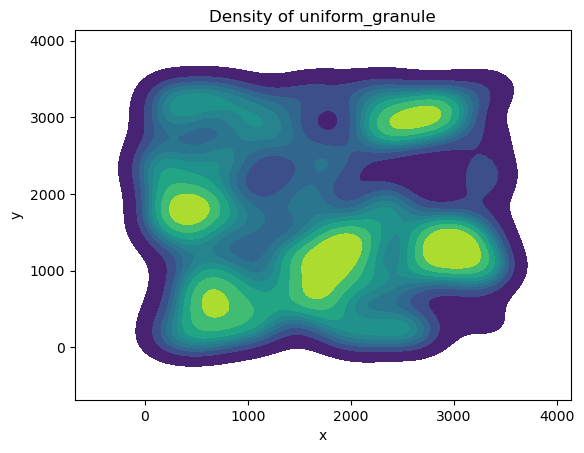

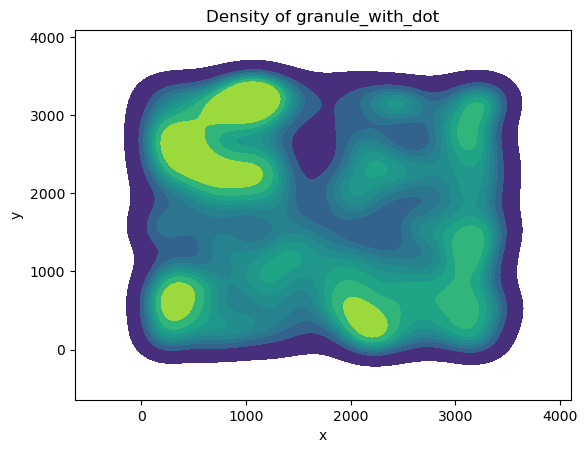

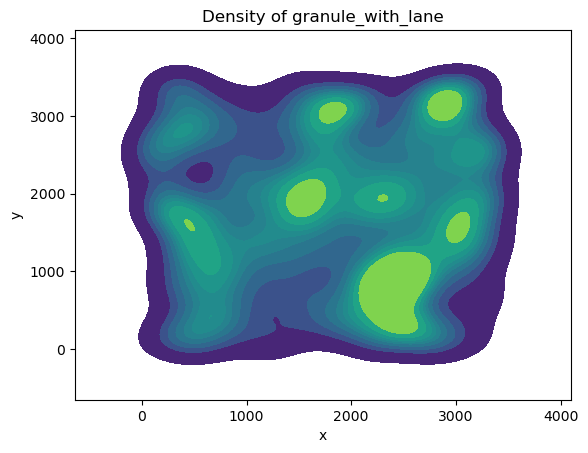

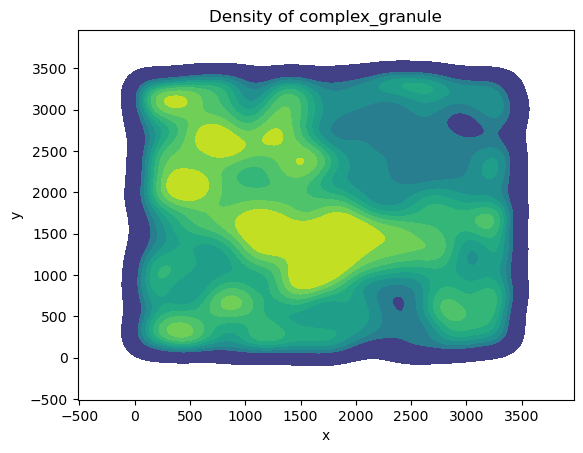

In [6]:
for granule_type in granule_types.keys():
    granule_df = df[df['granule_type'] == granule_type]
    sns.kdeplot(x=granule_df['x'], y=granule_df['y'], cmap="viridis", fill=True)
    plt.title(f"Density of {granule_type}")
    plt.show()


In [7]:
cluster_composition = df.groupby(['cluster', 'granule_type']).size().unstack(fill_value=0)
cluster_composition



granule_type,complex_granule,granule_with_dot,granule_with_lane,uniform_granule
cluster,,,,
-1,28868,7423,5960,3539
0,0,9,0,4
1,20,0,0,0
2,4,0,0,33
3,0,13,1,0
...,...,...,...,...
807,51,0,0,0
808,13,0,0,0
809,12,0,0,0


In [8]:
cluster_composition = df.groupby('cluster')['granule_type'].value_counts(normalize=True)
cluster_composition

cluster  granule_type     
-1       complex_granule      0.630443
         granule_with_dot     0.162110
         granule_with_lane    0.130159
         uniform_granule      0.077288
 0       granule_with_dot     0.692308
                                ...   
 807     complex_granule      1.000000
 808     complex_granule      1.000000
 809     complex_granule      1.000000
 810     complex_granule      1.000000
 811     complex_granule      1.000000
Name: granule_type, Length: 1170, dtype: float64